# Reliability analysis using OpenTURNS

This notebook presents the main steps of the uncertainty quantification framework. 

The analytical case of the cantilever beam in flexion illustrates the tools offered by OpenTURNS to perform a typical reliability analysis study.  

## 1. Analytical case: cantilever beam in flexion

We are interested in the vertical deviation $Y$ of a diving board created by a young diver. 

We consider a child whose weight generates a force $F$ approximately equal to 300N, considered hereafter as a random variable. 

<img src="figures/beam.png"  width=300>


The Following inputs are considered as independent random variables: 


 * $E$ : Young modulus (Pa), &nbsp;&nbsp;        Beta($\alpha = 0.9, \beta = 3.5, a=65.0 \times 10^9, b=75.0 \times 10^9$)
 * $F$ : Loading (N), &nbsp;&nbsp;               Lognormal($\mu_F=300.0, \sigma_F=30.0$)
 * $L$ : Length of beam ($m$), &nbsp;&nbsp;        Uniform(min=2.5, max= 2.6)
 * $I$ : Moment of inertia ($m^4$), &nbsp;&nbsp; Beta($\alpha = 2.5, \beta = 4.0, a = 1.3 \times 10^{-7}, b = 1.7 \times 10^{-7}$).

The vertical deviation is given by the following expression: 

$$
Y  = \frac{F\, L^3}{3 \, E \, I}
$$

In [1]:
import numpy as np
import pandas as pd
import openturns as ot
import copulogram as cp 
import matplotlib.pyplot as plt

### [Step A]: model definition

Function in OpenTURNS can be defined either using `ot.SymbolicFunction` when the function is explicit, otherwise it can be done using `ot.PythonFunction`

In [2]:
deflection_function = ot.SymbolicFunction(['E', 'F', 'L', 'I'], ['F*L^3/(3*E*I)'])
# Testing the function
x_test = [7e+10, 300, 2.5, 1.5e-07]
print(f"deflection({x_test}) = {deflection_function(x_test)}")

deflection([70000000000.0, 300, 2.5, 1.5e-07]) = [0.14881]


### [Step B]: uncertainty model definition

See the large catalogue of marginals and copulas available in OpenTURNS: 

http://openturns.github.io/openturns/latest/user_manual/probabilistic_modelling.html

In [3]:
E = ot.Beta(0.9, 3.5, 6.5e+10, 7.5e+10)
F = ot.LogNormalMuSigma(300, 30, 0.0).getDistribution()
L = ot.Uniform(2.5, 2.6)
I = ot.Beta(2.5, 4., 1.3e-07, 1.7e-07)
marginals = [E, F, L, I]
joint_distribution = ot.ComposedDistribution(marginals)
joint_distribution.setDescription(['E', 'F', 'L', 'I'])
dim = joint_distribution.getDimension()
joint_distribution

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 3.5, a = 6.5e+10, b = 7.5e+10)"
1,F,"LogNormal(muLog = 5.69881, sigmaLog = 0.0997513, gamma = 0)"
2,L,"Uniform(a = 2.5, b = 2.6)"
3,I,"Beta(alpha = 2.5, beta = 4, a = 1.3e-07, b = 1.7e-07)"


### [Step C]: uncertainty propagation

#### Monte Carlo propagation

In [4]:
size = 1000
x_MC_sample = joint_distribution.getSample(size)
y_MC_sample = deflection_function(x_MC_sample)

Other sampling methods available.

**For mean estimation:** 
- 1D Deterministic quadratures (Gauss-Legendre, Gauss-Legendre, Féjer)
- multi-D Deterministic quadratures (regular, sparse grids)
- Quasi-Monte Carlo, Randomized Quasi-Monte Carlo 
- Latin Hypercube Sampling
- Optimal Latin Hypercube Sampling

**For rare event estimation:**
- FORM/SORM
- Importance Sampling
- Line Sampling
- Subset Sampling
- Cross-entropy Importance Sampling
- Non-Adaptive Importance Sampling
  
This notebook illustrates all rare event estimation (reliability analysis) methods on this case. 

#### Data visualization


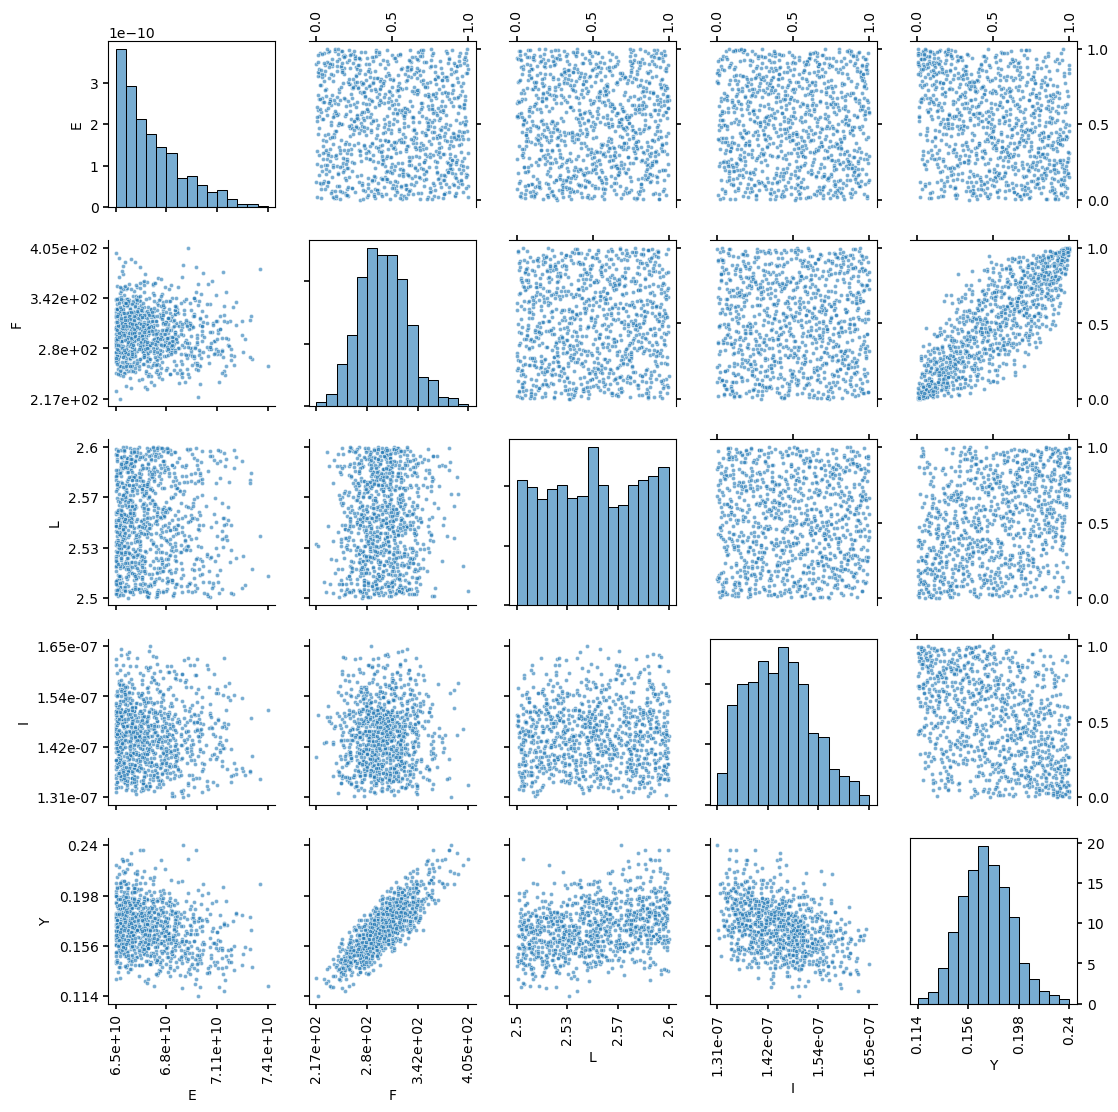

In [5]:
data = pd.DataFrame(np.array(x_MC_sample), columns=list(joint_distribution.getDescription()))
data['Y'] = np.array(y_MC_sample)
copulogram = cp.Copulogram(data)
copulogram.draw(alpha=0.6, marker='.');

In [6]:
threshold = 0.22 # not rare (order of 10^-2)
#threshold = 0.3 # rare (order of 10^-6)

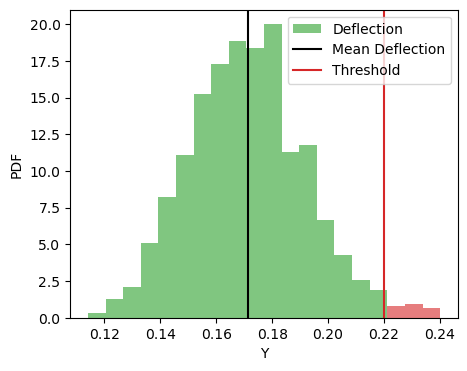

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
N, bins, patches = ax.hist(data['Y'], bins=20, density=True, alpha=0.6, color='C2', label="Deflection")
for i in range(17, 20):
    patches[i].set_facecolor('C3')
plt.axvline(data['Y'].mean(), color='k', label="Mean Deflection")
plt.axvline(threshold, color='C3', label="Threshold")
plt.xlabel("Y")
plt.ylabel("PDF")
plt.legend();

In [8]:
data['is_failed'] = 0
data.loc[data[data['Y'] > threshold].index, 'is_failed'] = 1
data

,E,F,L,I,Y,is_failed
0,6.556900e+10,248.570237,2.566372,1.351704e-07,0.158018,0
1,6.524430e+10,248.649297,2.509214,1.450224e-07,0.138389,0
2,6.791527e+10,290.912215,2.586424,1.366305e-07,0.180811,0
3,6.534302e+10,292.790268,2.554007,1.442033e-07,0.172555,0
4,6.592971e+10,255.116358,2.554393,1.524680e-07,0.141000,0
...,...,...,...,...,...,...
995,7.306792e+10,269.227472,2.575628,1.368787e-07,0.153315,0
996,6.516621e+10,299.347457,2.534934,1.364402e-07,0.182806,0
997,6.548499e+10,277.743249,2.534510,1.358582e-07,0.169425,0
998,6.524223e+10,331.680927,2.509664,1.599354e-07,0.167484,0


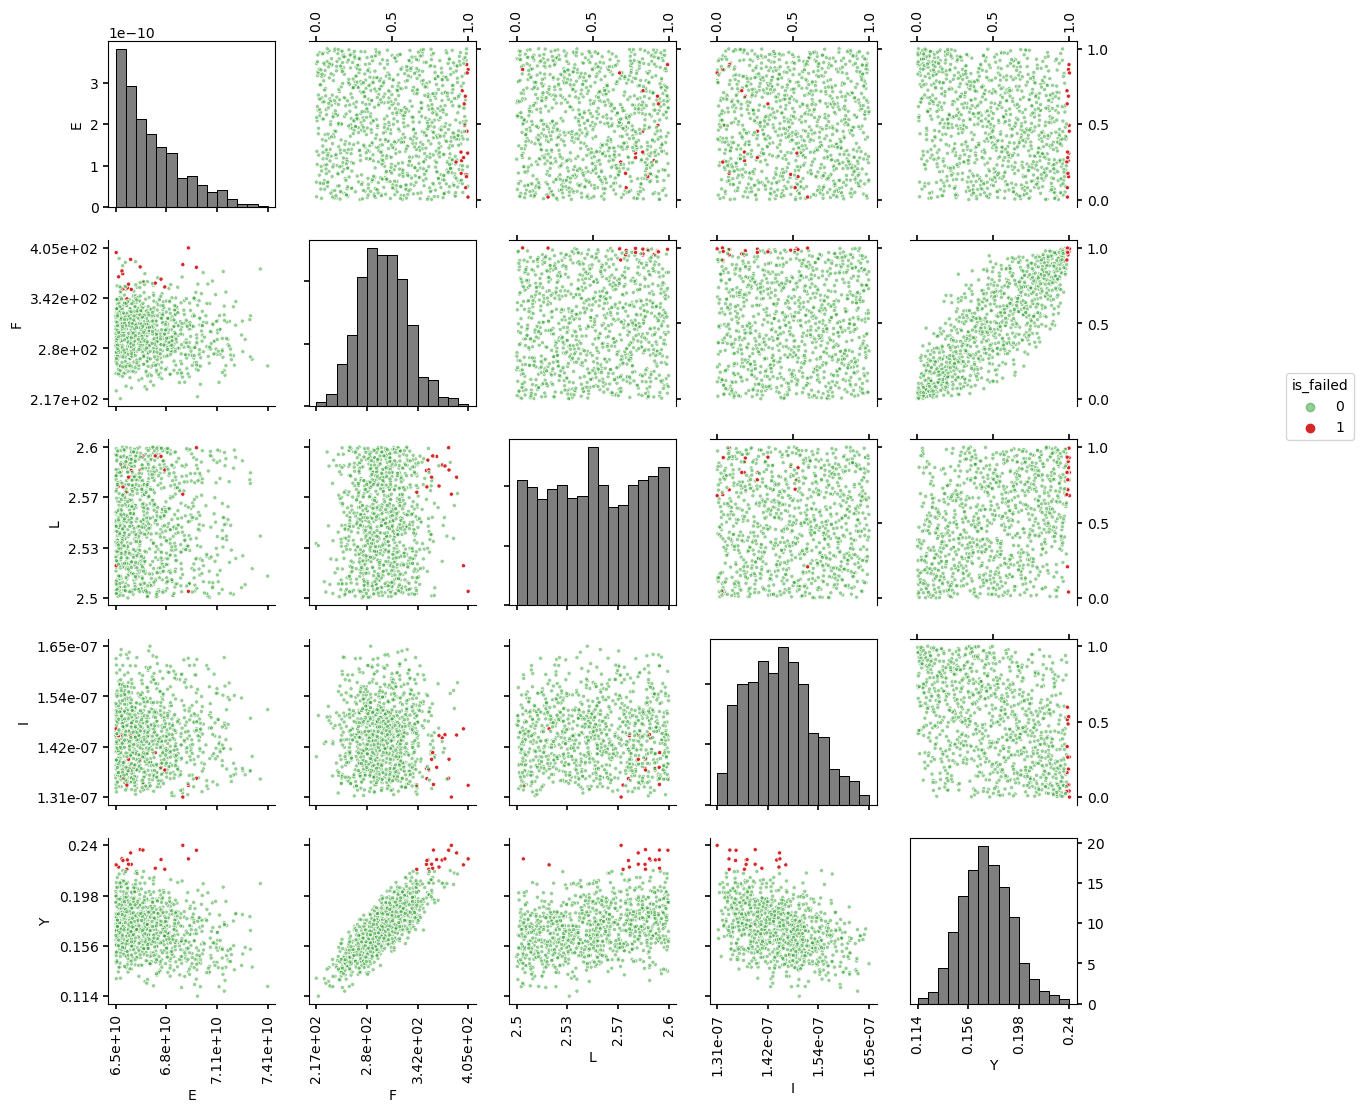

In [9]:
import seaborn as sns
from matplotlib.colors import to_rgba
# Define tailored binary colorbar
my_palette = sns.color_palette([to_rgba('C2', 0.5), to_rgba('C3', 1.)], as_cmap=True)

copulogram = cp.Copulogram(data[['E', 'F', 'L', 'I', 'Y', 'is_failed']])
copulogram.draw(hue='is_failed', hue_colorbar=my_palette, marker='.', kde_on_marginals=False);

In [10]:
# Monte Carlo failure probability 
MC_pf = data['is_failed'].mean()
print(f"Monte Carlo pf: {MC_pf}")

Monte Carlo pf: 0.018


#### Exact propagation as a reference (using powerful arithmetic of probability distributions)

*Disclaimer: this approach is only possible for simple analytical models and used here to obtain reference values.*

In [11]:
exact_Y = (F * L ** 3) / (3 * E * I)
exact_mean = exact_Y.getMean()[0]
exact_std = exact_Y.getStandardDeviation()[0]
exact_pf = exact_Y.computeProbability(ot.Interval([threshold], [1], [True], [False]))
print(f"Exact pf: {exact_pf:.2e}")

## OpenTURNS reliability analysis methods

See the following API page regarding the methods used below: 

https://openturns.github.io/openturns/latest/user_manual/threshold_probability_simulation_algorithms.html

### Define a generic `ThresholdEvent`

The `ThresholdEvent` object gathers all the inputs needed for a reliability problem

In [ ]:
threshold = 0.22 # not rare event (order of 10^-2)
#threshold = 0.3 # rare event (order of 10^-6)
X = ot.RandomVector(joint_distribution)
Y = ot.CompositeRandomVector(deflection_function, X)
failure_event = ot.ThresholdEvent(Y, ot.GreaterOrEqual(), threshold)

### FORM / SORM

In [ ]:
# Many other optimization algorithms (i.e., solvers) available.
# See: https://openturns.github.io/openturns/latest/user_manual/optimization.html
# Cobyla is a gradient-free solver. 
solver = ot.Cobyla()
starting_point = joint_distribution.getMean()
# See FORM API: https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.FORM.html
FORM_algo = ot.FORM(solver, failure_event, starting_point)
FORM_algo.run()
FORM_result = FORM_algo.getResult()
beta = FORM_result.getHasoferReliabilityIndex()
importance_factors = FORM_result.getImportanceFactors()
u_star = FORM_result.getStandardSpaceDesignPoint()
FORM_pf = FORM_result.getEventProbability()
print(f"FORM pf: {FORM_pf:.2e}")

FORM pf: 1.97e-02


In [ ]:
# See SORM API: https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.SORM.html
SORM_algo = ot.SORM(solver, failure_event, starting_point)
SORM_algo.run()
SORM_result = SORM_algo.getResult()
beta = SORM_result.getHasoferReliabilityIndex()
importance_factors = SORM_result.getImportanceFactors()
u_star = SORM_result.getStandardSpaceDesignPoint()
SORM_pf = SORM_result.getEventProbabilityBreitung()
print(f"SORM pf: {SORM_pf:.2e}")

SORM pf: 1.33e-02


### Importance Sampling / Quasi-Monte Carlo / LHS

In [ ]:
# Set random seed to exactly repeat results 
#ot.RandomGenerator.SetSeed(0)

In [ ]:
# Define an experiment (i.e., a sampling method among MC, IS, QMC, LHS)

## Monte Carlo 
mc_experiment = ot.MonteCarloExperiment()

## FORM - Importance sampling
importance_density = ot.Normal(u_star, [1.0] * dim) # Standard Gaussian centered around the FORM design point
is_experiment = ot.ImportanceSamplingExperiment(importance_density)

# Quasi-Monte Carlo
qmc_experiment = ot.LowDiscrepancyExperiment()
#qmc_experiment.setRandomize(True) # Randomized option

# LHS
lhs_experiment = ot.LHSExperiment()
#lhs_experiment.setAlwaysShuffle(True) # Randomized option

In [ ]:
standard_event = ot.StandardEvent(failure_event)
algo = ot.ProbabilitySimulationAlgorithm(standard_event, is_experiment) # The user can change the experiment with one defined above 
# Algorithm stopping criterions
algo.setMaximumOuterSampling(int(1e3))
algo.setBlockSize(1)
algo.setMaximumCoefficientOfVariation(0.05)
# Perform the simulation
algo.run()
simulation_results = algo.getResult()
simulation_pf = simulation_results.getProbabilityEstimate()
print(f'FORM -IS failure probability = {simulation_pf:.2e}')

FORM -IS failure probability = 1.37e-02


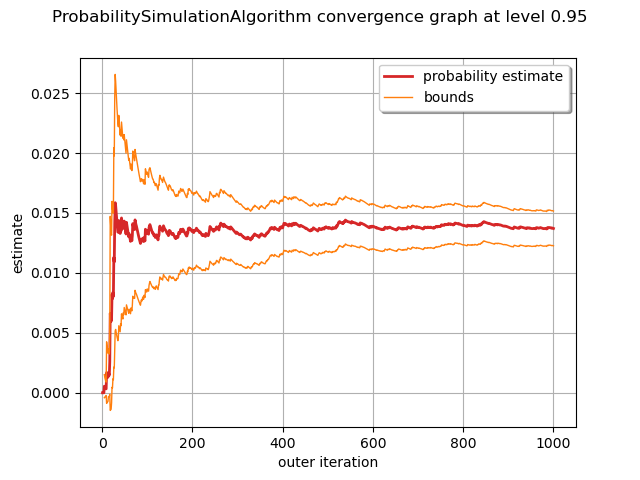

In [ ]:
palette = ot.Drawable.BuildDefaultPalette(10)
graph = algo.drawProbabilityConvergence(0.95)
graph.setColors([palette[3], palette[1], palette[1]])
graph

### Subset sampling

In [ ]:
SS_algo = ot.SubsetSampling(failure_event)
SS_algo.setMaximumOuterSampling(int(1e4))
SS_algo.run()
SS_results = SS_algo.getResult()
levels = SS_algo.getThresholdPerStep()
SS_pf = SS_results.getProbabilityEstimate()
print(f'Subset sampling failure probability = {SS_pf:.2e}')

Subset sampling failure probability = 1.44e-02


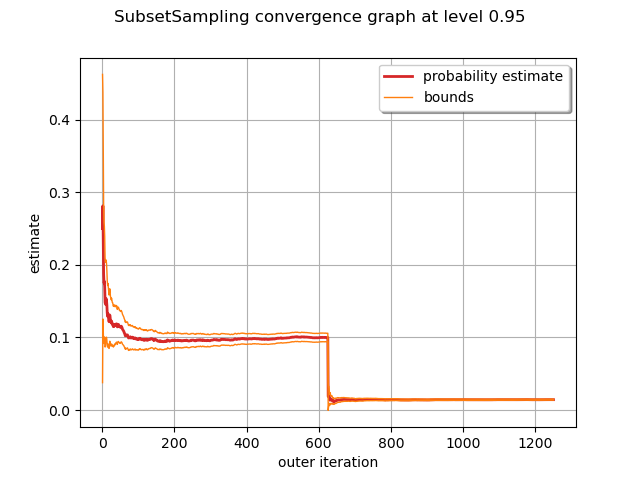

In [ ]:
graph = SS_algo.drawProbabilityConvergence(0.95)
graph.setColors([palette[3], palette[1], palette[1]])
graph

### Line Sampling

In [ ]:
solver = ot.Brent()
root_strategy = ot.MediumSafe(solver)
sampling_strategy = ot.RandomDirection()

LS_algo = ot.AdaptiveDirectionalStratification(failure_event, root_strategy, sampling_strategy)
LS_algo.setMaximumCoefficientOfVariation(0.1)
LS_algo.setMaximumOuterSampling(int(1e4))
LS_algo.setConvergenceStrategy(ot.Full())
LS_algo.run()

LS_results = LS_algo.getResult()
LS_pf = LS_results.getProbabilityEstimate()
print(f'Line sampling failure probability = {LS_pf:.2e}')

Line sampling failure probability = 1.29e-02


### Cross-entropy importance sampling 

In [ ]:
import openturns.experimental as otexp
CCIS = otexp.StandardSpaceCrossEntropyImportanceSampling(failure_event, 0.35)
CCIS.setMaximumOuterSampling(int(1e4))
CCIS.run()
CCIS_results = CCIS.getResult()
CCIS_pf = CCIS_results.getProbabilityEstimate()
print(f'Cross-entropy IS failure probability = {CCIS_pf:.2e}')

Cross-entropy IS failure probability = 1.32e-02
